# Master Time Features
## _Unencoding_ vs _Cyclical Encoding_ vs _Dummy Encoding_

Part of the following code comes from: https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                   parse_dates=['Date'], index_col=['Date'])

In [3]:
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


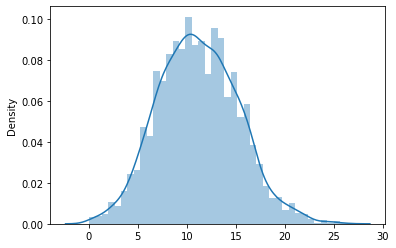

In [6]:
plt.figure()
sns.distplot(data, bins=40)
plt.show()

In [7]:
data['day_of_week'] = data.index.dayofweek
data['day_of_month'] = data.index.day
data['month'] = data.index.month

In [8]:
data.head()

,Temp,day_of_week,day_of_month,month
Date,,,,
1981-01-01,20.7,3,1,1
1981-01-02,17.9,4,2,1
1981-01-03,18.8,5,3,1
1981-01-04,14.6,6,4,1
1981-01-05,15.8,0,5,1


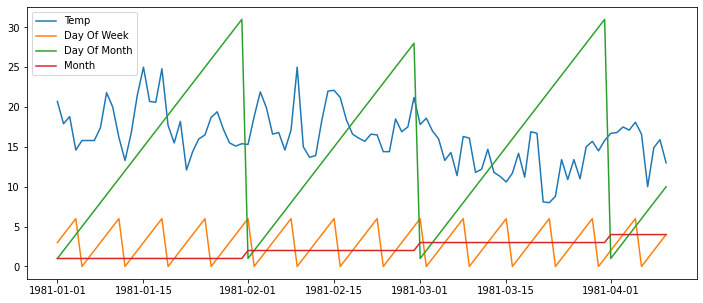

In [9]:
subdata = data[:100]
plt.figure(figsize=(12,5))
plt.plot(subdata.index, subdata['Temp'], label='Temp')
plt.plot(subdata.index, subdata['day_of_week'], label='Day Of Week')
plt.plot(subdata.index, subdata['day_of_month'], label='Day Of Month')
plt.plot(subdata.index, subdata['month'], label='Month')
plt.legend()
plt.show()

In [10]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from encoder import CyclicalEncoder

In [19]:
def build_model(input_size):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=10, 
                                    activation='selu', 
                                    kernel_initializer='lecun_normal', 
                                    input_shape=(input_size,)))
    model.add(tf.keras.layers.Dense(units=3, 
                                    activation='selu', 
                                    kernel_initializer='lecun_normal'))
    model.add(tf.keras.layers.AlphaDropout(0.2))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam()) 
    return model

def train_model(x_train, y_train, x_val, y_val):
    model = build_model(x_train.shape[1])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=5)
    ]

    history = model.fit(x_train, 
                        y_train, 
                        epochs=50, 
                        batch_size=8, 
                        validation_data=(x_val, y_val), 
                        verbose=0, 
                        callbacks=callbacks)
    
    return model, history

def eval_model(x_train, y_train, x_val, y_val, x_test, y_test, view=True):
    model, history = train_model(x_train, y_train, x_val, y_val)    
    
    if view:
        plt.figure()
        plt.plot(history.epoch, history.history['loss'], label='loss')
        plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
        plt.legend()
        plt.show()
    
    score = model.evaluate(x_test, y_test, batch_size=8, verbose=0)

    return score

In [20]:
from sklearn.model_selection import train_test_split

def print_shapes(x_train, x_val, x_test):
    print('\nTRAIN: ', x_train.shape,
          '\nVALIDATION: ', x_val.shape,
          '\nTEST: ', x_test.shape,)

def get_data(data, target):
    x = data.drop(target,1).values
    y = data[[target]].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=False)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

### Unencoded features

In [21]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data(data=data, target='Temp')

print_shapes(x_train, x_val, x_test)

scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print_shapes(x_train, x_val, x_test)

scores_unencoded = [eval_model(x_train, y_train, x_val, y_val, x_test, y_test, view=False) for _ in range(5)]


TRAIN:  (2190, 3) 
VALIDATION:  (730, 3) 
TEST:  (730, 3)

TRAIN:  (2190, 3) 
VALIDATION:  (730, 3) 
TEST:  (730, 3)


### Cyclical feature encoding

In [22]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data(data=data, target='Temp')

print_shapes(x_train, x_val, x_test)

scaler = CyclicalEncoder()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print_shapes(x_train, x_val, x_test)

scores_cyclical = [eval_model(x_train, y_train, x_val, y_val, x_test, y_test, view=False) for _ in range(5)]


TRAIN:  (2190, 3) 
VALIDATION:  (730, 3) 
TEST:  (730, 3)

TRAIN:  (2190, 6) 
VALIDATION:  (730, 6) 
TEST:  (730, 6)


### One-Hot feature encoding (aka dummy encoding)

In [23]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data(data=data, target='Temp')

print_shapes(x_train, x_val, x_test)

scaler = OneHotEncoder(drop='first')
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print_shapes(x_train, x_val, x_test)

scores_onehot = [eval_model(x_train, y_train, x_val, y_val, x_test, y_test, view=False) for _ in range(5)]


TRAIN:  (2190, 3) 
VALIDATION:  (730, 3) 
TEST:  (730, 3)

TRAIN:  (2190, 47) 
VALIDATION:  (730, 47) 
TEST:  (730, 47)


### Visualize results

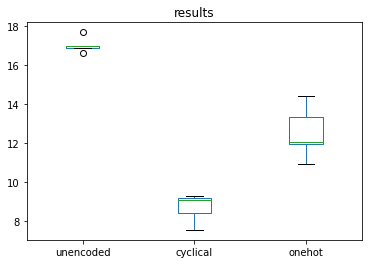

In [30]:
pd.DataFrame({'unencoded': scores_unencoded,
              'cyclical': scores_cyclical,
              'onehot': scores_onehot}).plot(kind='box').set_title('results');